<a href="https://colab.research.google.com/github/mjmousavi97/Deep-Learning-Tehran-uni/blob/main/HomeWorks/04%20HW/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ego1997","key":"d26531dac0eb01c2a2dd42efeddb3396"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:13<00:00, 261MB/s]
100% 2.29G/2.29G [00:13<00:00, 184MB/s]


In [5]:
with zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [6]:
base_directory = '/content/chest_xray/'

# Define sub-directories for training, validation, and testing data
sub_directories = ['train/', 'val/', 'test/']

# Name of classes
classes = os.listdir(os.path.join(base_directory, sub_directories[0]))

In [7]:
classes

['NORMAL', 'PNEUMONIA']

In [8]:
X = []
y = []

for sub_dir in sub_directories:
    for cls in classes:
        dir_path = os.path.join(base_directory, sub_dir, cls)
        for img in os.listdir(dir_path):
            image = cv2.imread(os.path.join(dir_path, img))
            image = cv2.resize(image, (128, 128))
            image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_RGB = image_RGB / 255.0
            X.append(image_RGB)
            y.append(cls)


In [9]:
# convert list to ndarray
X = np.asarray(X)
y = np.asarray(y)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (5856, 128, 128, 3)
y shape: (5856,)


In [10]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_indices, test_indices = next(splitter.split(X, y))
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_indices, test_indices = next(splitter.split(X_test, y_test))
X_val, X_test = X_test[val_indices], X_test[test_indices]
y_val, y_test = y_test[val_indices], y_test[test_indices]

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (3513, 128, 128, 3)
y_train shape: (3513,)
X_val shape: (1171, 128, 128, 3)
y_val shape: (1171,)
X_test shape: (1172, 128, 128, 3)
y_test shape: (1172,)


In [11]:
y_train_encoded = np.where(y_train == 'NORMAL', 0, 1)
y_val_encoded = np.where(y_val == 'NORMAL', 0, 1)
y_test_encoded = np.where(y_test == 'NORMAL', 0, 1)

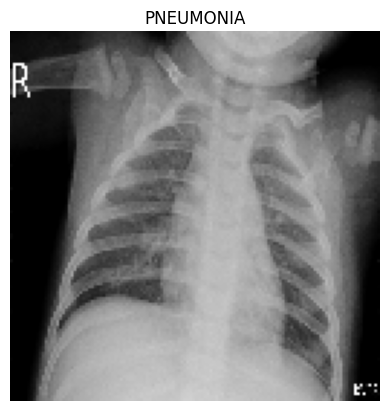

In [12]:
plt.imshow(X_train[0])
plt.title(y_train[0])
plt.axis("Off");
plt.show()

In [16]:
generator = ImageDataGenerator(shear_range=0.2,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               fill_mode='constant',
                               rotation_range=20,
                               horizontal_flip=True,
                               cval=0.2
                               )

In [17]:
batch_size = 32

train_generator = generator.flow(X_train, y_train_encoded, batch_size=batch_size)
val_generator = generator.flow(X_val, y_val_encoded, batch_size=batch_size)
test_generator = generator.flow(X_test, y_test_encoded, batch_size=batch_size)

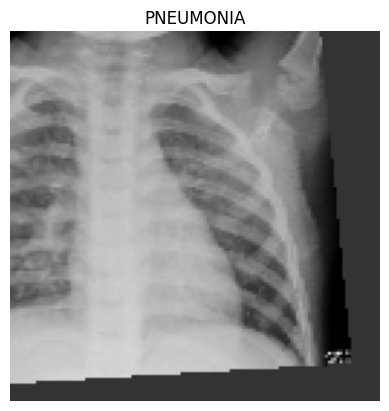

In [25]:
sample_image, sample_label = next(generator.flow(X_train, y_train_encoded, batch_size=1))

plt.imshow(sample_image[0])
plt.title(classes[sample_label[0]])
plt.axis("Off");
plt.show()

### Handling Class Imbalance with Class Weights

In many classification problems, the dataset may have **imbalanced classes**, meaning some classes have significantly fewer samples than others. Training a model on such a dataset without accounting for imbalance can lead to biased predictions toward the majority class.

To address this, we can use **class weights**, which assign a higher importance to underrepresented classes during training. This way, the model penalizes mistakes on minority classes more heavily.

We can compute class weights automatically using scikit-learn's `compute_class_weight` function with the `'balanced'` mode. The formula used is:

$$
\text{weight}_i = \frac{n_\text{samples}}{n_\text{classes} \times n_\text{samples in class i}}
$$

- `classes=[0, 1]` → List of all classes in the dataset  
- `y=y_train` → Array of training labels  

The output is an array like `[w0, w1]`, which gives the weight for each class. These weights can then be passed to the `class_weight` parameter in Keras models or certain scikit-learn classifiers (e.g., `LogisticRegression`, `RandomForestClassifier`, `SVC`) to handle class imbalance effectively.


In [30]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train_encoded)
class_weights = dict(zip([0, 1], class_weights))

In [35]:
for class_name, wight in class_weights.items():
    print(f'Class {class_name}: {wight:.4f}')

Class 0: 1.8489
Class 1: 0.6853



### 🛑 EarlyStopping Callback

The `EarlyStopping` callback is used to **prevent overfitting** and **reduce unnecessary training time** by stopping the training process when the monitored metric stops improving.

```python
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Metric to monitor (validation accuracy)
    patience=5,               # Number of epochs to wait for improvement
    verbose=1,                # Print early stopping messages
    restore_best_weights=True # Restore model weights from the best epoch
)
```

#### 🔎 Explanation of Parameters:
- **`monitor='val_accuracy'`** → The callback observes the validation accuracy. Training will stop when this metric no longer improves.  
- **`patience=5`** → Training continues for 5 more epochs after the last improvement before stopping.  
- **`verbose=1`** → Displays a message when early stopping is triggered.  
- **`restore_best_weights=True`** → Ensures that the final model keeps the weights from the epoch with the best validation accuracy.  

#### ✅ Benefits:
- Prevents overfitting by avoiding excessive training.  
- Saves computation time.  
- Ensures the model returns to its **best performance** rather than the last trained weights.  


In [36]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Monitor validation accuracy
    patience=5,               # Allow training to continue for 5 epochs without improvement
    verbose=1,                # Print messages about early stopping
    restore_best_weights=True # Restore model weights to the best epoch
)

### Model Checkpoint Callback

The `ModelCheckpoint` callback is used to automatically save the model during training.  
It ensures that the **best version of the model** (based on a monitored metric) is stored for later use.

- `filepath='tmp/checkpoint'`  
  Specifies the path and filename where the model checkpoint will be saved.  
  The file will be updated each time a better model is found.

- `monitor='val_accuracy'`  
  Indicates which metric to monitor. Here, validation accuracy (`val_accuracy`) is used.

- `save_best_only=True`  
  Ensures that only the best-performing model (with the highest validation accuracy) is saved.  
  If set to `False`, the model is saved after every epoch.

- `verbose=1`  
  Prints a message whenever the model is saved.

**In summary:**  
`ModelCheckpoint` prevents losing the best model during training.  
Even if the model overfits or performance decreases in later epochs, you will always have access to the best saved version.


In [39]:
checkpoints = ModelCheckpoint(
    'tmp/checkpoint.keras',    # The file path must end with .keras for the Keras model format
    monitor='val_accuracy',    # Monitor validation accuracy
    save_best_only=True,       # Save only the best model based on the monitored metric
    verbose=1                  # Print a message when the model is saved
)

# Create the model

In [41]:
input_layer = layers.Input(shape=(128, 128, 3))

eficientNet = tf.keras.applications.EfficientNetB0(include_top=False,
                                                   weights='imagenet',
                                                   input_tensor=input_layer)
x = eficientNet(input_layer, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)

output_layer = layers.Dense(1, activation='sigmoid')(x)

model = Model(input_layer, output_layer)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
